In [2]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np

import automembrane.util as u
from automembrane.energy import getEnergy2DClosed, getEnergy2DOpen

from pathlib import Path

files = map(
    Path,
    [
        f"coordinates/{i}"
        for i in [
            "cell1/34D-grid2-s3-acta1_001_16.txt",
            "cell2/34D-grid3-ActA1_007_16.txt",
            "cell2/34D-grid3-ActA1_013_16.txt",
            "cell3/34D-grid2-s2_002_16.txt",
            "cell3/34D-grid2-s5_005_16.txt",
            "cell3/34D-grid3-ActA1_020_16.txt",
            "cell3/34D-grid3-s6_005_16.txt",
            "cell4/34D-grid2-s3_028_16.txt",
            "cell5/34D-grid3-ActA1_001_16.txt",
            "cell5/34D-grid3-ActA1_002_16.txt",
            "cell5/34D-grid3-ActA1_003_16.txt",
            "cell5/34D-grid3-ActA1_004_16.txt",
        ]
    ],
)


parameters = {
    "Kb": 1,  # Bending modulus
    "Kbc": 0,  # Constant of bending modulus vs protein density
    "Ksg": 0,  # Global stretching modulus
    "At": 0,  # Preferred area
    "epsilon": 0,  # Binding energy per protein
    "Kv": 0,  # pressure-volume modulus
    "Vt": 0,  # Volume target
}

u.matplotlibStyle(medium=10)

(216, 2)
(217, 2)
coordinates/cell1/34D-grid2-s3-acta1_001_16.txt Energy:  68.169136


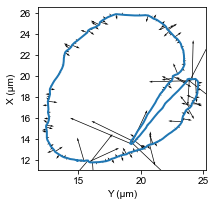

(153, 2)
(154, 2)
coordinates/cell2/34D-grid3-ActA1_007_16.txt Energy:  36.404644


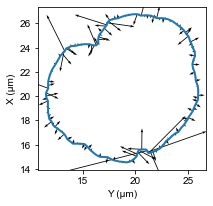

(151, 2)
(152, 2)
coordinates/cell2/34D-grid3-ActA1_013_16.txt Energy:  59.554543


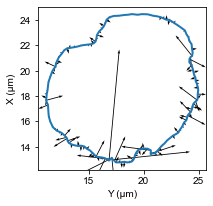

(196, 2)
(197, 2)
coordinates/cell3/34D-grid2-s2_002_16.txt Energy:  210.31732


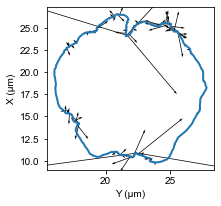

(195, 2)
(196, 2)
coordinates/cell3/34D-grid2-s5_005_16.txt Energy:  343.2256


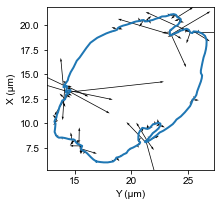

(192, 2)
(193, 2)
coordinates/cell3/34D-grid3-ActA1_020_16.txt Energy:  131.40492


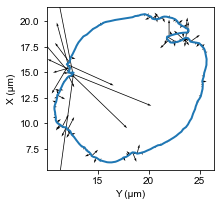

(172, 2)
(173, 2)
coordinates/cell3/34D-grid3-s6_005_16.txt Energy:  78.936775


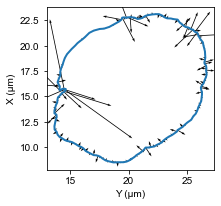

(195, 2)
(196, 2)
coordinates/cell4/34D-grid2-s3_028_16.txt Energy:  81.01627


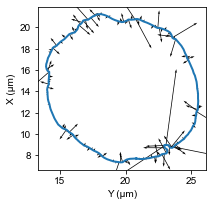

(168, 2)
(169, 2)
coordinates/cell5/34D-grid3-ActA1_001_16.txt Energy:  64.486664


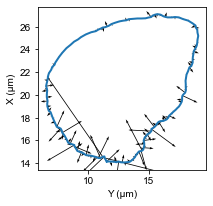

(217, 2)
(218, 2)
coordinates/cell5/34D-grid3-ActA1_002_16.txt Energy:  93.15904


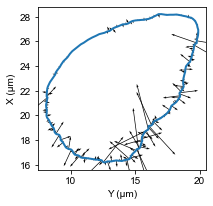

(204, 2)
(205, 2)
coordinates/cell5/34D-grid3-ActA1_003_16.txt Energy:  61.269012


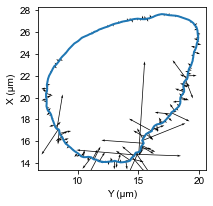

(152, 2)
(153, 2)
coordinates/cell5/34D-grid3-ActA1_004_16.txt Energy:  39.554295


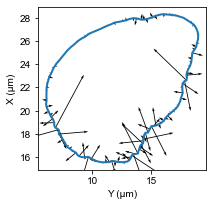

In [3]:
f_energy = partial(getEnergy2DClosed, **parameters)

for file in files:
    coords = np.loadtxt(file)
    coords = np.vstack((coords, coords[0])) # Energy expects last point to equal first
    energy = f_energy(coords)
    print(file, "Energy: ", energy)

    forces = -u.egrad(f_energy)(coords)

    fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    ax.plot(coords[:, 0], coords[:, 1])

    ax.quiver(
        coords[:, 0],
        coords[:, 1],
        forces[:, 0],
        forces[:, 1],
        label="force",
    )
    ax.set_ylabel(r"X (μm)")
    ax.set_xlabel(r"Y (μm)")
    plt.show()
